#Functions and code for plotting MEATseq m6A probability stats and read clustering

#jup notebook for analyzing 1x601 Chromatin Fiber-seq and MCviPI methylation efficiency and nuc call measurements
#DiMeLo V2 trial1 - 1x 601, HsCA, H3, XlCA, naked, DiMeLo v Fiberseq, pA-Hia5, MCviPI

In [1]:
#Input Megaladon output - mod_mappings.bam (filter by length to keep file size small)
#Template - 1x601.fa
#Functions:
# parse_bam6_fast - takes in bam file, reads through each read entry and outputs prob score at each A and coverage at each position along the given template. Other outputs include smoothed/sliding window averaged prob score, binary output for m6A call at each A position, number of modified A's and number of A's per read for other statistics, readids.
# extract_Ml_Aa_fast - takes in Mm and Ml from Megaladon output for each read. converts to array with just m6A calls with the correct index (removes mC prob scores)
# m6A_seqmap_prob_fast - takes in positions of A's and T's along template and assigns prob scores from Ml of megaladon output

In [2]:
%%bash
#mkdir '/home/groups/astraigh/ont_minion/jups/DiMeLo_v2_invitro'
mkdir '/home/groups/astraigh/ont_minion/jups/DiMeLo_v2_invitro/20221104_v2_trial1_1x601_multiplex'

In [1]:
##Replace <outdir> with output directory
outfolder = '/home/groups/astraigh/ont_minion/jups/DiMeLo_v2_invitro/20221104_v2_trial1_1x601_multiplex'

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kde
%matplotlib inline

import math

import pysam
from Bio import SeqIO

from scipy import sparse

from sklearn import cluster, datasets, mixture, decomposition

import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
#enter name of folder that contains bar1.1, bar1.2,.. etc. bam files mod_basecalled from megalodon
folder_name = '/scratch/groups/astraigh/minion_seq/megalodon/DiMeLo_v2_invitro_trial1/'

In [4]:
Barcode_name = {}

In [30]:
#List Barcode titles to be used for graphs here: (For example)
Barcode_name['21'] = 'CA Chr, free pA-Hia5'
Barcode_name['03'] = 'H3 Chr, free pA-Hia5'
Barcode_name['23'] = 'Naked, free pA-Hia5'
Barcode_name['07'] = 'Xl CA Chr, free pA-Hia5'
Barcode_name['08'] = 'CA Chr G1, free pA-Hia5'
Barcode_name['09'] = 'Xl CA Chr G1, free pA-Hia5'
Barcode_name['10'] = 'Xl CA Chr G4, free pA-Hia5'
Barcode_name['11'] = 'Naked, Untreated'
Barcode_name['12'] = 'CA Chr, free MCviPI'
Barcode_name['13'] = 'H3 Chr, free MCviPI'
Barcode_name['15'] = 'Naked, free MCviPI'
Barcode_name['14'] = 'Xl CA Chr, free MCviPI'
Barcode_name['16'] = 'CA Chr G1, free MCviPI'
Barcode_name['17'] = 'Xl CA Chr G1, free MCviPI'
Barcode_name['18'] = 'Xl CA Chr G4, free MCviPI'



In [6]:
Barcode_list = [i for i in Barcode_name.keys()]

In [7]:
Barcode_list

['21',
 '03',
 '23',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18']

In [8]:
#reading in template into string - filepath/template.fa
array_seq = SeqIO.read("/home/groups/astraigh/ont_minion/plasmids/pGEM_3z_601.fa", "fasta")
array_str = str(array_seq.seq)

In [9]:
#array_str = array_str2[1770:2525]

In [10]:
len(array_str)

3022

In [11]:
#identifying indices of A's and T's for assigning mod probs to right positions

A_pos = []
T_pos = []
for basepos in range(0,len(array_str)-1):
    if array_str[basepos]=='A':
        A_pos.append(basepos)
    elif array_str[basepos]=='T':
        T_pos.append(basepos)

In [12]:
#identifying indices of C's and G's for assigning mod probs to right positions

C_pos = []
G_pos = []
for basepos in range(0,len(array_str)-1):
    if array_str[basepos]=='C':
        C_pos.append(basepos)
    elif array_str[basepos]=='G':
        G_pos.append(basepos)

In [13]:
#to use later to filter out GpC's from the C's
GC_pos = []
for i in range(0,len(array_str)):
    if array_str[i] == 'C':
        if array_str[i-1] == 'G':
            GC_pos.append(i+1)

In [14]:
# extracting m6A prob from Ml, counting A
# input Mm Ml from bam and thr
# output - Mm first value, truncated m6A prob, total A count

In [15]:
def extract_Ml_Aa_fast(Mm, Ml):
         
    first=Mm.split(';')[0]
    if 'C+m' in first:
        A_n=len(Mm.split(';')[1].split(','))-1
        Mm_Aa = Mm.split(';')[1].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa = np.array(Ml[0-A_n:],dtype=int)

    elif 'A+a' in first:
        A_n=len(Mm.split(';')[0].split(','))-1        
        Mm_Aa = Mm.split(';')[0].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa=np.array(Ml[0:A_n],dtype=int)
    
    return Mm_Aa_start, Ml_Aa, A_n

In [16]:
def extract_5mC_fast(Mm, Ml):
         
    first=Mm.split(';')[0]
    if 'A+a' in first:
        C_n=len(Mm.split(';')[1].split(','))-1
        Mm_Cc = Mm.split(';')[1].split(',')[1:]
        Mm_Cc_start = int(Mm_Cc[0])
        Ml_Cc = np.array(Ml[0-C_n:],dtype=int)

    elif 'C+m' in first:
        C_n=len(Mm.split(';')[0].split(','))-1        
        Mm_Cc = Mm.split(';')[0].split(',')[1:]
        Mm_Cc_start = int(Mm_Cc[0])
        Ml_Cc=np.array(Ml[0:C_n],dtype=int)
    
    return Mm_Cc_start, Ml_Cc, C_n

In [17]:
# m6A_seqmap_prob_fast - takes in A or T pos array and readmap start, returns mod prob values assigned to A's along the template
# input arguments - A pos array, T pos array, pos of read along template, if strand=rev, Mm_start, truncated Ml prob values, read length, template length) thresholding done later
# output - m6A prob score along template, coverage along template - for each read

In [18]:
def m6A_seqmap_prob_fast(A_pos_array, T_pos_array, Readmap_start, rev_strand, Mm_start, Ml_Aa, readlength, templatelength = 3022):
    readfilter = False
    if rev_strand == False:
      
    #finding position of first A
        if (Readmap_start < A_pos_array[0]):
                first_A_index = A_pos_array[0]
                
        for i in range(0,len(A_pos_array)-1):
            if ((A_pos_array[i]) <= Readmap_start) and (Readmap_start < (A_pos_array[i+1])):
                if A_pos_array[i] == Readmap_start:
                    first_A_index = i + Mm_start
                else:
                    first_A_index = i+1+Mm_start
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,len(Ml_Aa)-1):
            if first_A_index + j <= len(A_pos_array)-1:
                A_index = A_pos_array[first_A_index+j]
                AT_prob_read[A_index] = Ml_Aa[j]
            else:
                readfilter = True
        
    elif rev_strand == True:

        if (Readmap_start < T_pos_array[0]):
                first_T_index = T_pos_array[0]

    #finding position of first T
        for i in range(0,len(T_pos_array)-1):
            if ((T_pos_array[i]) <= Readmap_start) and (Readmap_start < (T_pos_array[i+1])):
                if T_pos_array[i] == Readmap_start:
                    first_T_index = i + Mm_start
                else:
                    first_T_index = i+1+Mm_start
                
                #print(T_pos_array[i], Readmap_start, T_pos_array[first_T_index], T_pos_array[i+1], rev_strand)
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,(len(Ml_Aa)-1)):
            if first_T_index + j <= len(T_pos_array)-1:
                T_index = T_pos_array[first_T_index+j]
                AT_prob_read[T_index] = Ml_Aa[j]
            else:
                readfilter = True
                
    #sequence coverage
    Readmap_end = Readmap_start + readlength - 1
    AT_pos_read = np.zeros(templatelength,dtype=int)
    for k in range(Readmap_start, Readmap_end):
        AT_pos_read[k] = 1
    
    return AT_prob_read, AT_pos_read, readfilter

In [19]:
def mC_seqmap_prob_fast(C_pos_array, G_pos_array, Readmap_start, rev_strand, Mm_start, Ml_Cc, readlength, templatelength = 3022):
    
    if rev_strand == False:
      
    #finding position of first C
        if (Readmap_start < C_pos_array[0]):
                first_C_index = C_pos_array[0]
                
        for i in range(0,len(C_pos_array)-1):
            if ((C_pos_array[i]) <= Readmap_start) and (Readmap_start < (C_pos_array[i+1])):
                if C_pos_array[i] == Readmap_start:
                    first_C_index = i + Mm_start
                else:
                    first_C_index = i+1+Mm_start
                
        #sequence pos of all C's in read
        CG_prob_read = np.zeros(templatelength,dtype=int)
        for j in range(0,(len(Ml_Cc)-1)):
            C_index = C_pos_array[first_C_index+j]
            CG_prob_read[C_index] = Ml_Cc[j]
            
    elif rev_strand == True:

        if (Readmap_start < G_pos_array[0]):
                first_G_index = G_pos_array[0]

    #finding position of first G
        for i in range(0,len(G_pos_array)-1):
            if ((G_pos_array[i]) <= Readmap_start) and (Readmap_start < (G_pos_array[i+1])):
                if G_pos_array[i] == Readmap_start:
                    first_G_index = i + Mm_start
                else:
                    first_G_index = i+1+Mm_start
                
                #print(G_pos_array[i], Readmap_start, G_pos_array[first_G_index], G_pos_array[i+1], rev_strand)
                
        #sequence pos of all C's in read
        CG_prob_read = np.zeros(templatelength,dtype=int)
        for j in range(0,(len(Ml_Cc)-1)):
            G_index = G_pos_array[first_G_index+j]
            CG_prob_read[G_index] = Ml_Cc[j]

    #sequence coverage
    Readmap_end = Readmap_start + readlength - 1
    CG_pos_read = np.zeros(templatelength,dtype=int)
    for k in range(Readmap_start, Readmap_end):
        CG_pos_read[k] = 1

    
    return CG_prob_read, CG_pos_read

In [20]:
def parse_bam6_fast(filename, numreads = 5000, templatelength = 3022):
    reader = pysam.AlignmentFile(filename, check_sq=False)
    bamiter= reader.fetch(until_eof=True)

    A_n=[]
    readids=[]
    rev_read_list=[]
    
    AT_prob_list = []
    coverage_Fwd = np.zeros(templatelength,dtype=int)
    coverage_Rev = np.zeros(templatelength,dtype=int)
    
    
    readfilter_list = []
    count = 0
    
    while True:
        try:
            r=bamiter.__next__()
            Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
            Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
            readid=r.query_name
            pos=r.reference_start
            #pos in bam is 1 indexed, python is 0 indexed
            pos=pos-1
            length=r.query_length
            rev_strand=r.is_reverse
            
            if count < numreads:
                if not Mm is None:

                    Mm_Aa_start, Ml_Aa, read_A_n = extract_Ml_Aa_fast(Mm, Ml)
                    if rev_strand ==True:
                        Mm_Aa_start = 0
                        Ml_Aa = Ml_Aa[::-1]
                    AT_prob_read, AT_pos_read, readfilter = m6A_seqmap_prob_fast(A_pos, T_pos, pos, rev_strand, Mm_Aa_start, Ml_Aa, length)
                    if readfilter == False:                    
                        AT_prob_list.append(AT_prob_read)
                        A_n+=[read_A_n]
                        readids+=[readid]
                        rev_read_list+=[rev_strand]

                        if rev_strand == False:
                            coverage_Fwd += AT_pos_read
                        elif rev_strand == True:
                            coverage_Rev += AT_pos_read

                        count += 1
                    else:
                        print(readid)

        except StopIteration:
            reader.close()

            
            AT_prob_arr = np.array(AT_prob_list)
            
            
            return AT_prob_arr, coverage_Fwd, coverage_Rev, A_n, readids, rev_read_list

In [21]:
def parse_bam6_mC(filename, numreads = 5000, templatelength = 3022):
    reader = pysam.AlignmentFile(filename, check_sq=False)
    bamiter= reader.fetch(until_eof=True)

    #A_n=[]
    C_n=[]
    readids=[]
    rev_read_list=[]
    
    AT_prob_list = []
    CG_prob_list = []
    coverage_Fwd = np.zeros(templatelength,dtype=int)
    coverage_Rev = np.zeros(templatelength,dtype=int)
    
    count = 0
    
    while True:
        try:
            r=bamiter.__next__()
            Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
            Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
            readid=r.query_name
            pos=r.reference_start
            #pos in bam is 1 indexed, python is 0 indexed
            pos=pos-1
            length=r.query_length
            rev_strand=r.is_reverse
            
            if count < numreads:
                if not Mm is None:
                    
                    #Mm_Aa_start, Ml_Aa, read_A_n = extract_Ml_Aa_fast(Mm, Ml)
                    Mm_Cc_start, Ml_Cc, read_C_n = extract_5mC_fast(Mm, Ml)
                    if rev_strand == True:
                        #Mm_Aa_start = 0
                        #Ml_Aa = Ml_Aa[::-1]
                        Mm_Cc_start = 0
                        Ml_Cc = Ml_Cc[::-1]

                    
                    #A_n+=[read_A_n]
                    C_n+=[read_C_n]
                    readids+=[readid]
                    rev_read_list+=[rev_strand]
                
                    #AT_prob_read, AT_pos_read = m6A_seqmap_prob_fast(A_pos, T_pos, pos, rev_strand, Mm_Aa_start, Ml_Aa, length)
                    CG_prob_read, CG_pos_read = mC_seqmap_prob_fast(C_pos, G_pos, pos, rev_strand, Mm_Cc_start, Ml_Cc, length)
                    
                    #AT_prob_list.append(AT_prob_read)
                    CG_prob_list.append(CG_prob_read)
                
                    if rev_strand == False:
                        coverage_Fwd += CG_pos_read
                    elif rev_strand == True:
                        coverage_Rev += CG_pos_read
            
                    count += 1
                    
        except StopIteration:
            reader.close()

            
            #AT_prob_arr = np.array(AT_prob_list)
            CG_prob_arr = np.array(CG_prob_list)
            
            return CG_prob_arr, coverage_Fwd, coverage_Rev, C_n, readids, rev_read_list

BarCode All through for loop

In [22]:
import time

In [23]:
def by_barcode(folder_path, Nuc = 'A', barcodes_list = Barcode_list, numreads = 5000):
    N_prob_arr_bar = {new_list: [] for new_list in barcodes_list} 
    N_coverage_Fwd_bar = {new_list: [] for new_list in barcodes_list} 
    N_coverage_Rev_bar = {new_list: [] for new_list in barcodes_list} 
    N_n_bar = {new_list: [] for new_list in barcodes_list} 
    readids_bar = {new_list: [] for new_list in barcodes_list} 
    rev_read_list_bar = {new_list: [] for new_list in barcodes_list} 
    filename = {}
    for i in barcodes_list:
        start_time = time.time()
        #Iterate through file names here: (for example)
        if Nuc == 'A':
            filename[i] = folder_path + 'barcode' + i + '/mod_mappings_730bp.bam'
            N_prob_arr_bar[i], N_coverage_Fwd_bar[i], N_coverage_Rev_bar[i], N_n_bar[i], readids_bar[i], rev_read_list_bar[i] = parse_bam6_fast(filename[i], numreads)
        
        if Nuc == 'C':
            filename[i] = folder_path + 'barcode' + i + '_mC/mod_mappings_730bp.bam'
            N_prob_arr_bar[i], N_coverage_Fwd_bar[i], N_coverage_Rev_bar[i], N_n_bar[i], readids_bar[i], rev_read_list_bar[i] = parse_bam6_mC(filename[i], numreads)
        
        if Nuc == 'C_all':
            filename[i] = folder_path + 'barcode' + i + '/mod_mappings_730bp.bam'
            N_prob_arr_bar[i], N_coverage_Fwd_bar[i], N_coverage_Rev_bar[i], N_n_bar[i], readids_bar[i], rev_read_list_bar[i] = parse_bam6_mC(filename[i], numreads)
        
        print('Finished barcode ', i, 'in ', "--- %s seconds ---" % (time.time() - start_time))
        
    return N_prob_arr_bar, N_coverage_Fwd_bar, N_coverage_Rev_bar, N_n_bar, readids_bar, rev_read_list_bar

In [109]:
AT_prob_arr_bar, AT_coverage_Fwd_bar, AT_coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar = by_barcode(folder_name, 'A', Barcode_list, 5000)

Finished barcode  21 in  --- 1.3648571968078613 seconds ---
Finished barcode  03 in  --- 1.3433423042297363 seconds ---
Finished barcode  23 in  --- 1.3203911781311035 seconds ---
Finished barcode  07 in  --- 1.2029175758361816 seconds ---
Finished barcode  08 in  --- 1.3541221618652344 seconds ---
Finished barcode  09 in  --- 1.3664746284484863 seconds ---
Finished barcode  10 in  --- 1.3405330181121826 seconds ---
Finished barcode  11 in  --- 1.5438644886016846 seconds ---
Finished barcode  12 in  --- 1.5291600227355957 seconds ---
Finished barcode  13 in  --- 1.458026647567749 seconds ---
Finished barcode  14 in  --- 0.0012040138244628906 seconds ---
Finished barcode  15 in  --- 1.3925056457519531 seconds ---
Finished barcode  16 in  --- 0.0011799335479736328 seconds ---
Finished barcode  17 in  --- 0.0007801055908203125 seconds ---
Finished barcode  18 in  --- 0.0007741451263427734 seconds ---


In [117]:
[np.shape(CG_prob_arr_bar[i]) for i in Barcode_list]

[(4228, 3022),
 (4599, 3022),
 (3560, 3022),
 (2344, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022),
 (5000, 3022)]

In [112]:
[np.shape(coverage_bar[i]) for i in Barcode_list]

KeyError: '21'

In [87]:
CG_prob_arr_bar, CG_coverage_Fwd_bar, CG_coverage_Rev_bar, C_n_bar, readids_bar, rev_read_list_bar = by_barcode(folder_name, 'C', Barcode_list, 5000)

Finished barcode  21 in  --- 1.004807949066162 seconds ---
Finished barcode  03 in  --- 1.1101064682006836 seconds ---
Finished barcode  23 in  --- 0.8138785362243652 seconds ---
Finished barcode  07 in  --- 0.535069465637207 seconds ---
Finished barcode  08 in  --- 1.2154717445373535 seconds ---
Finished barcode  09 in  --- 1.2447254657745361 seconds ---
Finished barcode  10 in  --- 1.2523460388183594 seconds ---
Finished barcode  11 in  --- 1.437279462814331 seconds ---
Finished barcode  12 in  --- 1.4075145721435547 seconds ---
Finished barcode  13 in  --- 1.3069303035736084 seconds ---
Finished barcode  14 in  --- 1.3826887607574463 seconds ---
Finished barcode  15 in  --- 1.2593584060668945 seconds ---
Finished barcode  16 in  --- 1.3765957355499268 seconds ---
Finished barcode  17 in  --- 1.3485660552978516 seconds ---
Finished barcode  18 in  --- 1.2560865879058838 seconds ---


In [86]:
CG_all_prob_arr_bar, CG_all_coverage_Fwd_bar, CG_all_coverage_Rev_bar, C_all_n_bar, readids_bar, rev_read_list_bar = by_barcode(folder_name, 'C_all', Barcode_list, 5000)

Finished barcode  21 in  --- 1.2675390243530273 seconds ---
Finished barcode  03 in  --- 1.1918983459472656 seconds ---
Finished barcode  23 in  --- 1.1623878479003906 seconds ---
Finished barcode  07 in  --- 1.1127922534942627 seconds ---
Finished barcode  08 in  --- 1.4502334594726562 seconds ---
Finished barcode  09 in  --- 1.3816969394683838 seconds ---
Finished barcode  10 in  --- 1.3462457656860352 seconds ---
Finished barcode  11 in  --- 1.7302091121673584 seconds ---
Finished barcode  12 in  --- 1.6732826232910156 seconds ---
Finished barcode  13 in  --- 1.5606153011322021 seconds ---
Finished barcode  14 in  --- 0.0030879974365234375 seconds ---
Finished barcode  15 in  --- 1.427657127380371 seconds ---
Finished barcode  16 in  --- 0.0015828609466552734 seconds ---
Finished barcode  17 in  --- 0.0011601448059082031 seconds ---
Finished barcode  18 in  --- 0.0006082057952880859 seconds ---


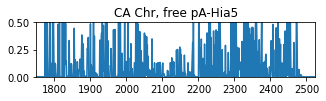

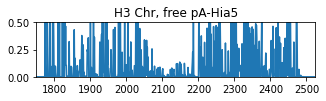

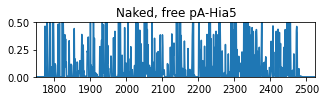

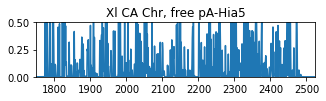

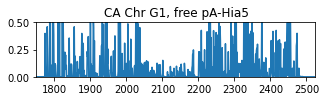

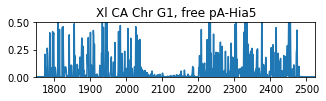

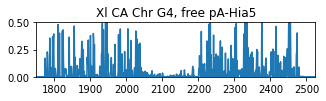

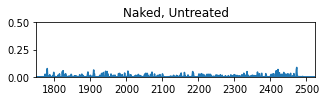

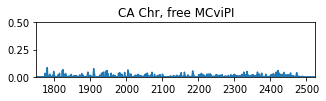

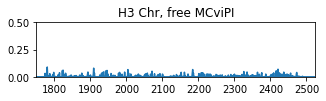

/home/groups/astraigh/miniconda3_py38_4.9.2/envs/meat/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/groups/astraigh/miniconda3_py38_4.9.2/envs/meat/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


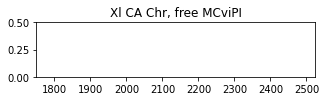

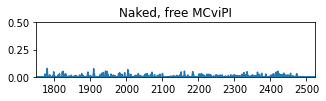

/home/groups/astraigh/miniconda3_py38_4.9.2/envs/meat/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/groups/astraigh/miniconda3_py38_4.9.2/envs/meat/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


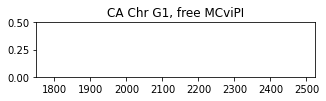

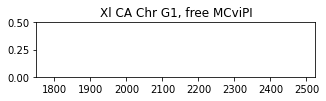

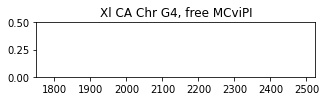

In [31]:
for Bar in Barcode_list:
    plt.figure(figsize=(5,1))
    plt.plot(np.nanmean(AT_prob_arr_bar[Bar]/256>0.88, axis = 0))
    plt.title(Barcode_name[Bar])
    plt.ylim(0,0.5)
    plt.xlim(1750,2525)
    plt.show()

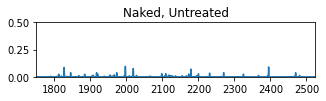

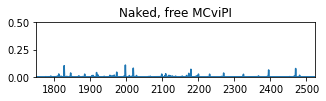

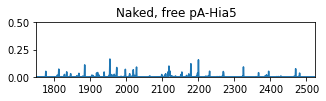

In [32]:
for Bar in ['11','15','23']:
    plt.figure(figsize=(5,1))
    plt.plot(np.nanmean(CG_prob_arr_bar[Bar]/256>0.88, axis = 0))
    plt.title(Barcode_name[Bar])
    plt.ylim(0,0.5)
    plt.xlim(1750,2525)
    plt.show()

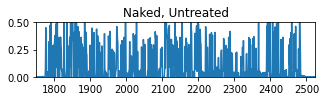

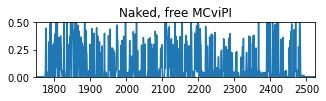

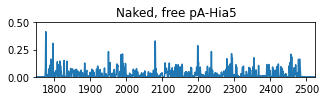

In [33]:
for Bar in ['11','15','23']:
    plt.figure(figsize=(5,1))
    plt.plot(np.nanmean(CG_all_prob_arr_bar[Bar]/256>0.5, axis = 0))
    plt.title(Barcode_name[Bar])
    plt.ylim(0,0.5)
    plt.xlim(1750,2525)
    plt.show()

In [35]:
#COVERAGE
def coverage(barcodes_list, coverage_Fwd_bar, coverage_Rev_bar, templatelength = 3022, label_name = Barcode_name):
    coverage_bar = {new_list: [] for new_list in barcodes_list}
    x = np.arange(templatelength)    
    for i in barcodes_list:
        coverage_bar[i] = coverage_Fwd_bar[i] + coverage_Rev_bar[i]
        plt.plot(x, np.array(coverage_bar[i]), label = label_name[i])
    plt.xlabel('bp of 1x601 plasmid', fontsize = 14)
    plt.ylabel('# of read', fontsize = 14)
    plt.title('coverage', fontsize=14)
    legend = plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.xlim(1770,2490)
    plt.show()
    return coverage_bar

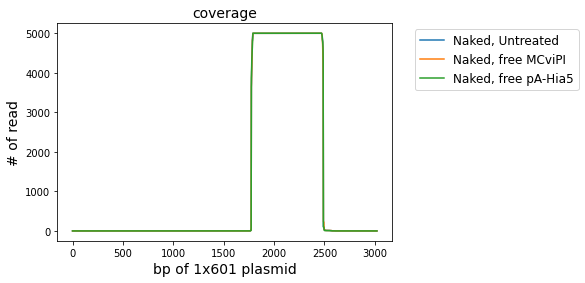

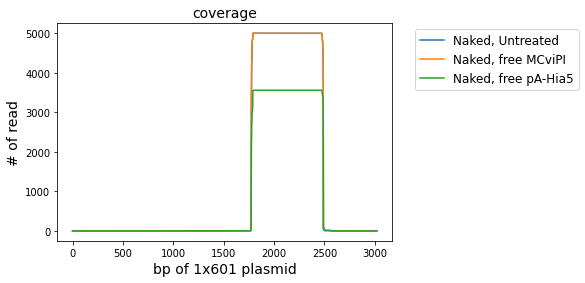

In [58]:
AT_coverage_bar = coverage(['11','15','23'], AT_coverage_Fwd_bar, AT_coverage_Rev_bar)
CG_coverage_bar = coverage(['11','15','23'], CG_coverage_Fwd_bar, CG_coverage_Rev_bar)

In [317]:
#Calculating FDR from CDF

In [37]:
barcodes_list = ['11','23']

In [38]:
AT_prob_arr_bar_trim750 = {}
for Bar in ['11','23']:
    AT_prob_arr_bar_trim750[Bar] = AT_prob_arr_bar[Bar][:,1750:2500]

In [39]:
histo = {new_list: [] for new_list in barcodes_list}
bin_edges = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar = {new_list: [] for new_list in barcodes_list}
cdf = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar[i] = np.reshape(AT_prob_arr_bar_trim750[i][AT_prob_arr_bar_trim750[i]>=0],-1)
    histo[i], bin_edges[i] = np.histogram(AT_prob_list_clean_bar[i]/255, density = True, bins=1000)
    cdf[i] = np.cumsum(histo[i])/np.nansum(histo[i])
    

In [40]:
#FDR calculation without binning

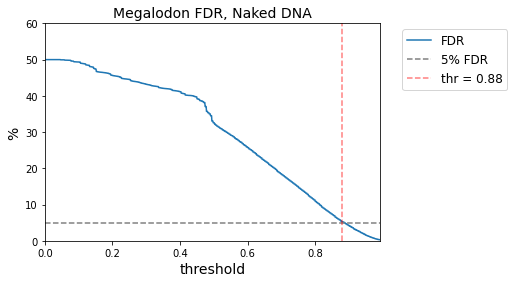

In [41]:
plt.plot(bin_edges['23'][:-1],np.divide((1-cdf['11']),((1-cdf['23'])+(1-cdf['11'])))*100, label = 'FDR' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.88, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.88')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Megalodon FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [317]:
#Calculating FDR from CDF

In [42]:
barcodes_list = Barcode_list

In [43]:
CG_prob_arr_bar_trim750 = {}
for Bar in barcodes_list:
    CG_prob_arr_bar_trim750[Bar] = CG_prob_arr_bar[Bar][:,1750:2500]

In [44]:
histo = {new_list: [] for new_list in barcodes_list}
bin_edges = {new_list: [] for new_list in barcodes_list}
CG_prob_list_clean_bar = {new_list: [] for new_list in barcodes_list}
cdf = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    CG_prob_list_clean_bar[i] = np.reshape(CG_prob_arr_bar_trim750[i][CG_prob_arr_bar_trim750[i]>=0],-1)
    histo[i], bin_edges[i] = np.histogram(CG_prob_list_clean_bar[i]/255, density = True, bins=1000)
    cdf[i] = np.cumsum(histo[i])/np.nansum(histo[i])
    

In [45]:
#FDR calculation without binning

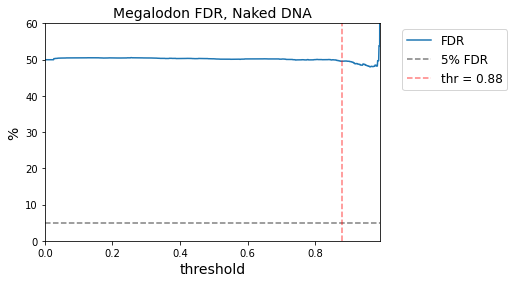

In [46]:
plt.plot(bin_edges['15'][:-1],np.divide((1-cdf['11']),((1-cdf['15'])+(1-cdf['11'])))*100, label = 'FDR' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.88, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.88')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Megalodon FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


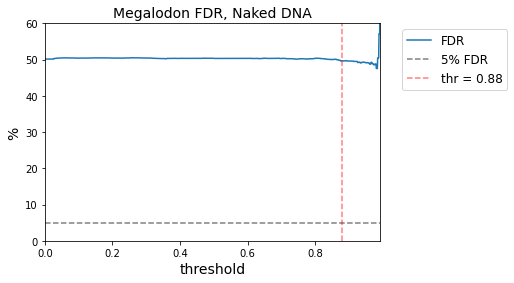

In [47]:
plt.plot(bin_edges['18'][:-1],np.divide((1-cdf['11']),((1-cdf['18'])+(1-cdf['11'])))*100, label = 'FDR' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.88, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.88')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Megalodon FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [136]:
#making a binary mod prob > thr array using numpy
def binary_mod(barcodes_list, AT_prob_arr_bar, AT_mod_arr_bar={}, thr=88):
    thr256 = thr/100*256
    try: AT_mod_arr_bar
    except NameError: 
        AT_mod_arr_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        AT_mod_arr_bar[i] = np.ndarray.astype(AT_prob_arr_bar[i] >= thr256, int)
    return AT_mod_arr_bar

In [164]:
AT_mod_arr_bar = {}
AT_mod_arr_bar = binary_mod(['11','15','23'], AT_prob_arr_bar)

In [178]:
CG_mod_arr_bar = {}
CG_mod_arr_bar = binary_mod(['11','15','23'], CG_prob_arr_bar, thr=50)

In [170]:
#making a binary mod prob > thr array using numpy
def frac_m6A(barcodes_list, AT_mod_arr_bar, A_n_bar, m6A_over_A_bar = {}):
    N_mod_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        print(np.shape(AT_mod_arr_bar[i]))
        N_mod_bar[i] = AT_mod_arr_bar[i].sum(axis = 1)
        print(np.shape(N_mod_bar[i]))
        print(np.shape(A_n_bar[i]))
        m6A_over_A_bar[i] = np.ndarray.astype(N_mod_bar[i]/A_n_bar[i], float)
    return m6A_over_A_bar

In [166]:
m6A_over_A_bar = {}
m6A_over_A_bar = frac_m6A(['11','15','23'], AT_mod_arr_bar, A_n_bar)

(5000, 3022)
(5000,)
(5000,)
(5000, 3022)
(5000,)
(5000,)
(5000, 3022)
(5000,)
(5000,)


In [179]:
Gp5mC_over_Gp5mC_bar = {}
Gp5mC_over_Gp5mC_bar = frac_m6A(['11','15','23'], CG_mod_arr_bar, C_n_bar)

(5000, 3022)
(5000,)
(5000,)
(5000, 3022)
(5000,)
(5000,)
(3560, 3022)
(3560,)
(3560,)


In [149]:
[np.nanmean(m6A_over_A_bar[i]) for i in ['11','15','23']]

[0.006612200838191109, 0.006718342837521238, 0.014599469404708501]

In [153]:
[np.nanmean(Gp5mC_over_Gp5mC_bar[i]) for i in ['11','15','23']]

[0.006612200838191109, 0.006718342837521238, 0.014599469404708501]

In [142]:
colorpal = ['#BB4420','#FFBC0A','#053C5E','#A9E5BB','#610345','#2D1E2F','#559CAD','#5E747F', '#FF0000', '#00FF00', '#FFFF00']

In [180]:
def plot_m6A_over_A_combined(barcodes_list, m6A_over_A_bar, ylimit=(0,22), xlimit = (0,1), num_bins = 100, label_name = Barcode_name, colorpal = ['#FFBC0A','#053C5E','#559CAD','#610345','#A9E5BB','#2D1E2F','#BB4420','#5E747F']):

    def export_legend(legend, filename="legend.png"):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi=300, bbox_inches=bbox)
        return
    fig, ax1 = plt.subplots(figsize = (7.2,2.4))
    barcodes_list_str = ''
    a = 0
    alp = [0.6,0.6,0.4,0.4,0.6,0.6,0.4,0.4]
    for i in barcodes_list:
        barcodes_list_str += '_' + str(i)
        ax1.hist(m6A_over_A_bar[i], bins = 75, density = True, alpha = alp[a], label = label_name[i], color = colorpal[a], histtype = 'barstacked')
        ax1.set_ylabel('frequency', fontsize = 14)
        ax1.set_ylim(0,20)
        ax1.set_xlabel('mA/A per read', fontsize = 14)
        ax = ax1.twinx()
        ax.hist(m6A_over_A_bar[i], bins = 1000, density = True, alpha = 1, label = label_name[i], cumulative=True, histtype='step', rwidth = 1, color = colorpal[a])
        ax.set_ylabel('fraction of reads', fontsize = 14)
        ax.set_ylim(0,1)
        a += 1
        legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1-a/6), loc='upper left')
        
    
    #plt.xlabel('mA/A (per read)', fontsize = 14)
    #plt.legend(fontsize=14)
    #legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1), loc='upper left')
    #plt.ylim(ylimit)
    plt.xlim(xlimit)
    plt.show()
    #if cumul == True:
    fig.savefig(outfolder+'plot_m6A_over_A_Cumulative_hist_combined_88_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    export_legend(legend, str(outfolder + 'plot_m6A_overA_Cumulative_hist_combined_legend_88_'+ barcodes_list_str + '.png'))
    #else:
    #    fig.savefig(outfolder+'plot_m6A_over_A_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    #    export_legend(legend, str(outfolder + 'plot_m6A_overA_legend_'+ barcodes_list_str + '.png'))
    

    
    return

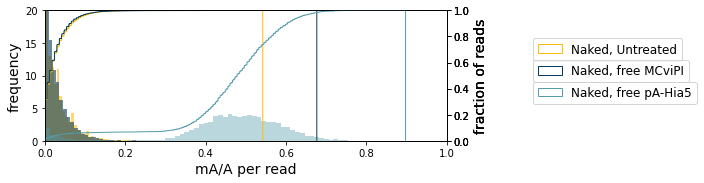

In [168]:
ax = plot_m6A_over_A_combined(['11','15','23'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

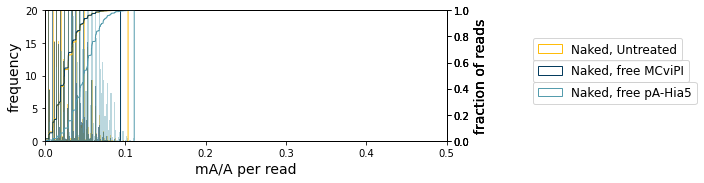

In [183]:
ax = plot_m6A_over_A_combined(['11','15','23'],Gp5mC_over_Gp5mC_bar, ylimit = [0,1], xlimit = [0,0.5], num_bins=1000)

### Binning and Sensitivity measurement

In [230]:
CG_prob_arr_bar_filt50 = {}
for i in ['11','15','23']:
    CG_prob_arr_bar_filt50[i] = CG_prob_arr_bar[i][:3560]
    CG_prob_arr_bar_filt50[i][CG_prob_arr_bar[i][:3560]<=130] = 0

In [233]:
np.shape(CG_prob_arr_bar_filt50['11'])

(3560, 3022)

#### Set bin and step sizes here:

In [260]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize, Binning to identify at least 1 mA probability
binsize = 20
stepsize = 1
templatelength = 3022

In [261]:
colorpal = ['#BB4420','#053C5E','#610345','#2D1E2F','#A9E5BB','#FFBC0A','#559CAD', '#5E747F', '#FF0000','#00FF00', '#FFFF00']

### Average probability for each bin on read, and then average and normalize to Fiberseq and untreated

In [269]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize , Binning by averaging probability
CG_prob_arr_bin_mA = {}
for i in ['11','15','23']:
    CG_prob_arr_bin_mA[i] = np.zeros((3560,int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        CG_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(CG_prob_arr_bar_filt50[i][:,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/home/groups/astraigh/miniconda3_py38_4.9.2/envs/meat/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/groups/astraigh/miniconda3_py38_4.9.2/envs/meat/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [270]:
Barcode_list = ['11','15','23']

In [271]:
CG_prob_arr_bin_mA_trim750 = {}
for Bar in Barcode_list:
    CG_prob_arr_bin_mA_trim750[Bar] = CG_prob_arr_bin_mA[Bar][:,1750:2500]

### Binned mA/A

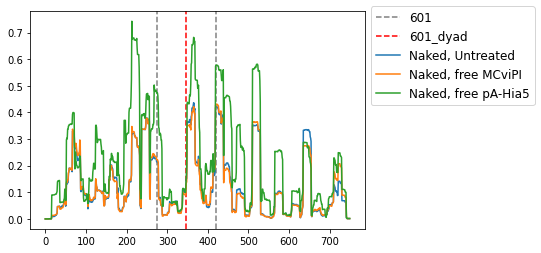

In [272]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')
for Bar in Barcode_list:
    plt.plot(np.nanmean(CG_prob_arr_bin_mA_trim750[Bar]>0, axis = 0), label = Barcode_name[Bar])
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))

plt.show()

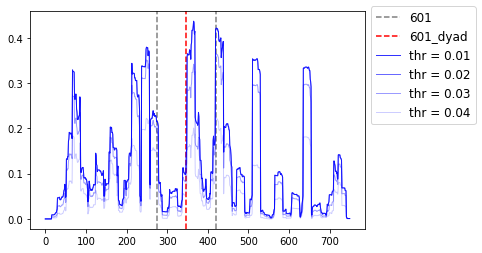

In [273]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

for thr in np.arange(0.01,0.05,0.01):
    plt.plot(np.nanmean(CG_prob_arr_bin_mA_trim750['11']>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*20, linewidth = 1-thr)
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
plt.show()

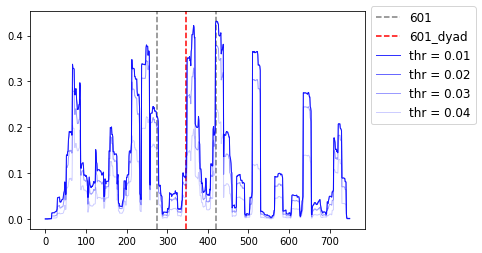

In [274]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

for thr in np.arange(0.01,0.05,0.01):
    plt.plot(np.nanmean(CG_prob_arr_bin_mA_trim750['15']>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*20, linewidth = 1-thr)
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
plt.show()

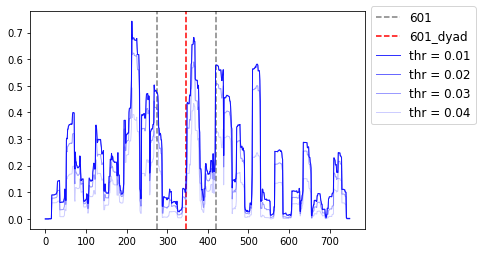

In [275]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

for thr in np.arange(0.01,0.05,0.01):
    plt.plot(np.nanmean(CG_prob_arr_bin_mA_trim750['23']>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*20, linewidth = 1-thr)
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
plt.show()

In [200]:
seq_601 = 'ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG'

In [442]:
array_str.index(seq_601)-1770

274

In [454]:
array_str.index('GCGCGTACG')-1770

347

In [104]:
array_str.index(seq_601)-1770+len(seq_601)

421

### Identifying GpC sites within the DNA sequence

In [132]:
GC_pos = []
for i in range(0,len(array_str)):
    if array_str[i] == 'G':
        if array_str[i+1] == 'C':
            GC_pos.append(i+1)

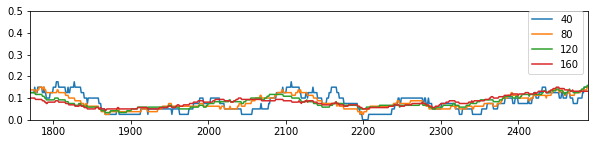

In [133]:
GC_array = np.zeros(len(array_str))
GC_array[:] = np.nan
GC_array[GC_pos] = 1
plt.figure(figsize=(10,2))
for interval in range(40,200,40):
    plt.plot((np.nancumsum(GC_array)[interval:] - np.nancumsum(GC_array)[:-interval])/interval, label = interval)
plt.legend(bbox_to_anchor = (1,1.05))
plt.ylim(0,0.5)
plt.xlim(1770,2490)
plt.show()

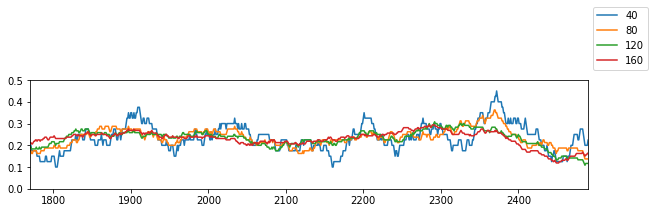

In [134]:
AT_array = np.zeros(len(array_str))
AT_array[:] = np.nan
AT_array[A_pos] = 1
AT_array[A_pos] = 1
plt.figure(figsize=(10,2))
for interval in range(40,200,40):
    plt.plot((np.nancumsum(AT_array)[interval:] - np.nancumsum(AT_array)[:-interval])/interval, label = interval)
plt.legend(bbox_to_anchor = (1,1.05))
plt.xlim(1770,2490)
plt.ylim(0,0.5)
plt.show()

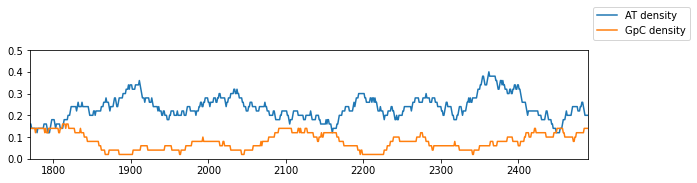

In [136]:
plt.figure(figsize=(10,2))
interval = 50
plt.plot((np.nancumsum(AT_array)[interval:] - np.nancumsum(AT_array)[:-interval])/interval, label = 'AT density')
plt.plot((np.nancumsum(GC_array)[interval:] - np.nancumsum(GC_array)[:-interval])/interval, label = 'GpC density')
plt.legend(bbox_to_anchor = (1,1.05))
plt.xlim(1770,2490)
plt.ylim(0,0.5)
plt.show()

### Mapping GpC methylation afer binning

In [188]:
AT_prob_arr_bar_filt50 = {}
for i in Barcode_list:
    AT_prob_arr_bar_filt50[i] = AT_prob_arr_bar[i]
    AT_prob_arr_bar_filt50[i][AT_prob_arr_bar[i]<=130] = 0

In [189]:
for bp in ['A','T','AT']:
    AT_prob_arr_bar_filt50[bp] = np.zeros((5000,3022))
    AT_prob_arr_bar_filt50[bp][:] = np.NaN
for baseind in A_pos:
    AT_prob_arr_bar_filt50['A'][:,baseind] = 130
for baseind in T_pos:
    AT_prob_arr_bar_filt50['T'][:,baseind] = 130
for baseind in A_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 130
for baseind in T_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 130


#### Set bin and step sizes here:

In [190]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize, Binning to identify at least 1 mA probability
binsize = 50
stepsize = 1
templatelength = 3022

In [191]:
Barcode_name['A'] = 'A density'
Barcode_name['T'] = 'T density'
Barcode_name['AT'] = 'AT density'


In [192]:
colorpal = ['#BB4420','#053C5E','#610345','#2D1E2F','#A9E5BB','#FFBC0A','#559CAD', '#5E747F', '#FF0000','#00FF00', '#FFFF00']

### Average probability for each bin on read, and then average and normalize to Fiberseq and untreated

In [193]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize , Binning by averaging probability
AT_prob_arr_bin_mA = {}
for i in ['11','15','23', 'A', 'T', 'AT']:
    AT_prob_arr_bin_mA[i] = np.zeros((4800,int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        AT_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(AT_prob_arr_bar_filt50[i][:4800,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [194]:
Barcode_list = ['11','15','23']

In [195]:
AT_prob_arr_bin_mA_trim750 = {}
for Bar in Barcode_list:
    AT_prob_arr_bin_mA_trim750[Bar] = AT_prob_arr_bin_mA[Bar][:,1750:2500]

### Binned mA/A

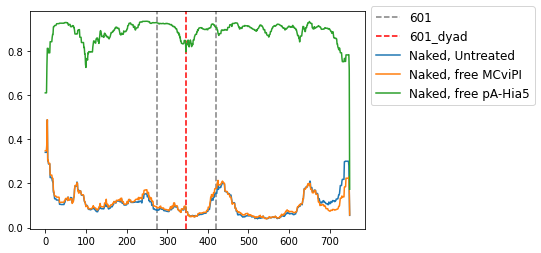

In [196]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')
for Bar in Barcode_list:
    plt.plot(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]>0.6, axis = 0), label = Barcode_name[Bar])
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))

plt.show()

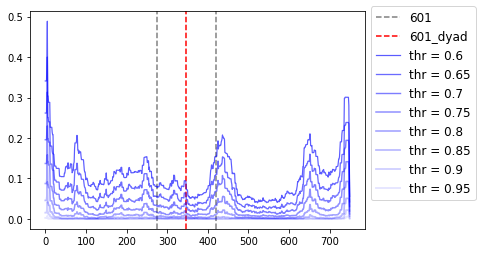

In [197]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

for thr in np.arange(0.6,1.0,0.05):
    plt.plot(np.nanmean(AT_prob_arr_bin_mA_trim750['11']>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*thr, linewidth = thr*2)
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
plt.show()

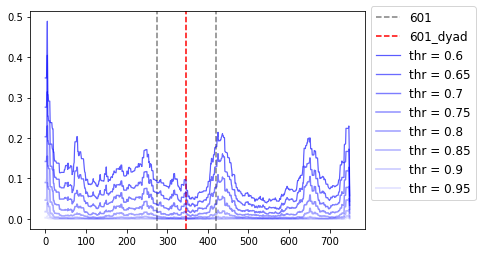

In [198]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

for thr in np.arange(0.6,1.0,0.05):
    plt.plot(np.nanmean(AT_prob_arr_bin_mA_trim750['15']>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*thr, linewidth = thr*2)
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
plt.show()

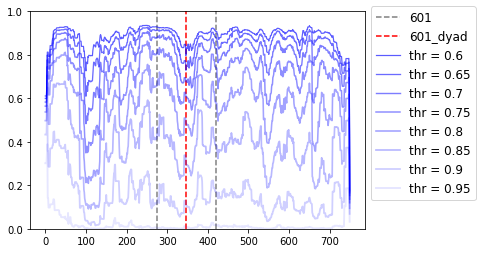

In [199]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

for thr in np.arange(0.6,1.0,0.05):
    plt.plot(np.nanmean(AT_prob_arr_bin_mA_trim750['23']>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*thr, linewidth = thr*2)
plt.ylim(0,1)
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
plt.show()

### Derivative of the average methylation

In [872]:
def simple_smoothing(array_like, bin_size):
    smoothed_array = (np.cumsum(np.pad(np.nanmean(array_like, 0), pad_width=smoobin, mode='edge'))[smoobin:]-np.cumsum(np.pad(np.nanmean(array_like, 0), pad_width=smoobin, mode='edge'))[:-smoobin])/smoobin
    return smoothed_array

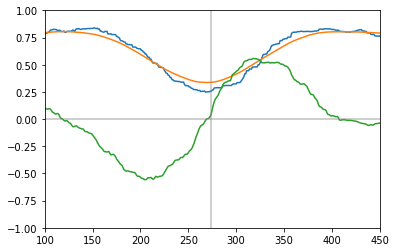

In [886]:
smoobin = 100
Bar = '03'
plt.plot(np.pad(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar], 0), pad_width=smoobin, mode='edge')[int(smoobin/2):])
plt.plot(simple_smoothing(AT_prob_arr_bin_mA_trim450[Bar], smoobin))
plt.plot(np.gradient(simple_smoothing(AT_prob_arr_bin_mA_trim450[Bar], smoobin))*smoobin)
plt.xlim(smoobin,450)
plt.ylim(-1,1)
plt.axvline(224+smoobin/2, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.show()

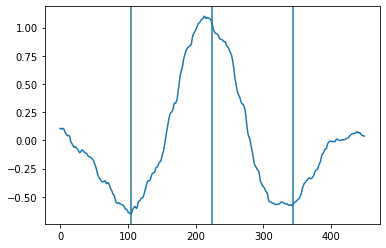

In [887]:
Bar = '03'
plt.plot(np.gradient(np.cumsum(np.gradient(simple_smoothing(AT_prob_arr_bin_mA_trim450[Bar], smoobin))*smoobin)[smoobin:]-np.cumsum(np.gradient(simple_smoothing(AT_prob_arr_bin_mA_trim450[Bar], smoobin))*smoobin)[:-smoobin]))
plt.axvline(224)
plt.axvline(224-120)
plt.axvline(224+120)

In [869]:
plt.plot(np.cumsum(np.pad(np.nanmean(np.gradient(simple_smoothing(AT_prob_arr_bin_mA_trim450[Bar], smoobin)), 0)), pad_width=smoobin, mode='edge'))

TypeError: _pad_dispatcher() missing 1 required positional argument: 'pad_width'

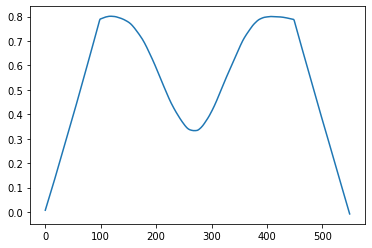

In [828]:
plt.plot(np.cumsum(np.gradient(simple_smoothing(AT_prob_arr_bin_mA_trim450[Bar], smoobin))))

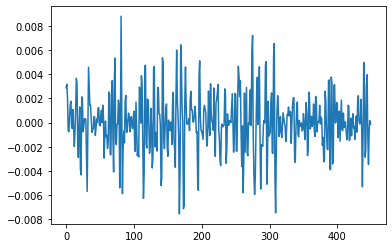

In [707]:
plt.plot(np.gradient(np.gradient(np.nanmean(AT_prob_arr_bin_mA_trim450['21'], 0))))

# Determining saturation from Fiberseq:

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


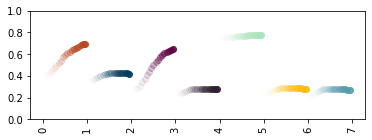

In [512]:
plt.figure(figsize = (6,2))
for interval in np.arange(0,200,10):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/200, np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval]),2), alpha = (interval/200)*(interval/200), color = colorpal[iterate])
        iterate+=1
        plt.xticks(rotation = 90)
        plt.ylim(0,1)
plt.show()

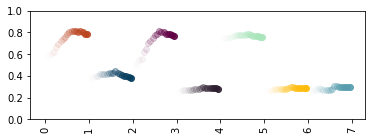

In [513]:
plt.figure(figsize = (6,2))
for interval in np.arange(0,200,10):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/200, np.round((np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval])+ np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374+interval:]))/2,2), alpha = (interval/200)*(interval/200), color = colorpal[iterate])
        iterate+=1
        plt.xticks(rotation = 90)
        plt.ylim(0,1)
plt.show()

In [559]:
test = np.asarray([[1,2,3,4,5],[6,7,8,9,10]])
np.shape(test)

(2, 5)

In [563]:
np.delete(test, [1], axis = 1)

array([[ 1,  3,  4,  5],
       [ 6,  8,  9, 10]])

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


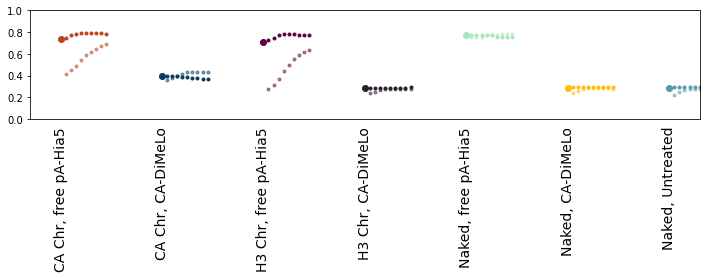

In [586]:
plt.figure(figsize = (12,2))
for interval in np.arange(0,200,20):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/400, np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval]),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.scatter(iterate + interval/400, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)),2), alpha = 1, color = colorpal[iterate], marker = '.')
        iterate+=1
        plt.tick_params(axis = 'x', bottom = False)
        plt.ylim(0,1)

iterate = 0
    
for Bar in Barcode_list:
    plt.scatter(Barcode_name[Bar], np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]),2), color = colorpal[iterate])
    iterate+=1
    plt.xticks(rotation = 90, fontsize = 14)        
plt.show()

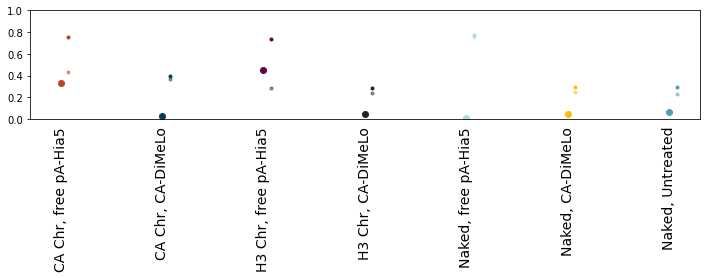

In [644]:
plt.figure(figsize = (12,2))
for interval in [30]:
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/400, np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval]),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.scatter(iterate + interval/400, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)),2), alpha = 1, color = colorpal[iterate], marker = '.')
        iterate+=1
        plt.tick_params(axis = 'x', bottom = False)
        plt.ylim(0,1)

iterate = 0
    
for Bar in Barcode_list:
    plt.scatter(Barcode_name[Bar], np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)) - np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval]),2), color = colorpal[iterate])
    iterate+=1
    plt.xticks(rotation = 90, fontsize = 14)        
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


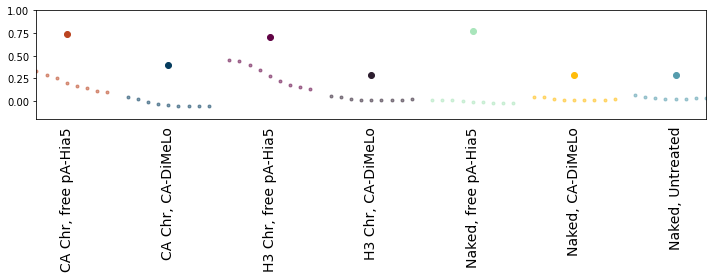

In [604]:
plt.figure(figsize = (12,2))
for interval in np.arange(0,200,20):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + (-0.5 + interval/200), np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)) - np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval]),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        iterate+=1
        plt.tick_params(axis = 'x', bottom = False)
        plt.ylim(-0.2,1)

iterate = 0

for Bar in Barcode_list:
    plt.scatter(Barcode_name[Bar], np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]),2), color = colorpal[iterate])
    iterate+=1
    plt.xticks(rotation = 90, fontsize = 14)        
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


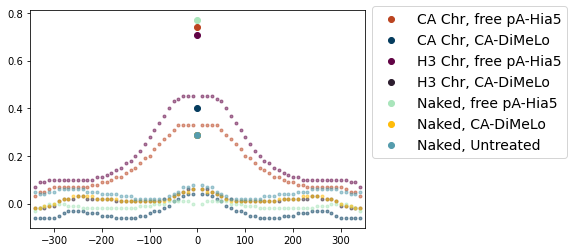

In [633]:
plt.figure(figsize = (6,4))
iterate = 0
    
for Bar in Barcode_list:
    for interval in np.arange(0,350,10):
    
        plt.plot(-interval, np.round(np.subtract(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)), np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval])),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.plot(interval, np.round(np.subtract(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)), np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval])),2), alpha = 0.5, color = colorpal[iterate], marker = '.')

    iterate+=1

plt.xlim(-350,350)

iterate = 0
for Bar in Barcode_list:
    plt.scatter(0, np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]),2), color = colorpal[iterate], label = Barcode_name[Bar])
    iterate+=1

plt.legend(fontsize = 14, bbox_to_anchor = (1,1.05))
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


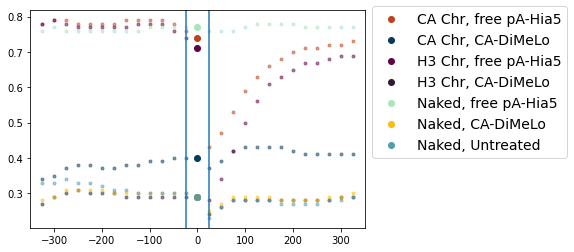

In [640]:
plt.figure(figsize = (6,4))
iterate = 0
    
for Bar in Barcode_list:
    for interval in np.arange(0,350,25):
    
        plt.plot(-interval, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim750[Bar],np.arange(374-interval,374+interval), axis = 1)),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.plot(interval, np.round((np.nanmean(AT_prob_arr_bin_mA_trim750[Bar][:,374-interval:374+interval])),2), alpha = 0.5, color = colorpal[iterate], marker = '.')

    iterate+=1

plt.xlim(-350,350)

plt.axvline(-25)
plt.axvline(25)

iterate = 0
for Bar in Barcode_list:
    plt.scatter(0, np.round(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]),2), color = colorpal[iterate], label = Barcode_name[Bar])
    iterate+=1

plt.legend(fontsize = 14, bbox_to_anchor = (1,1.05))
plt.show()

In [645]:
AT_prob_arr_bin_mA_trim450 = {}
for Bar in Barcode_list:
    AT_prob_arr_bin_mA_trim450[Bar] = AT_prob_arr_bin_mA_trim750[Bar][:,150:600]

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


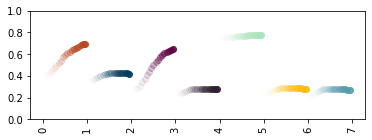

In [646]:
plt.figure(figsize = (6,2))
for interval in np.arange(0,200,10):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/200, np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval]),2), alpha = (interval/200)*(interval/200), color = colorpal[iterate])
        iterate+=1
        plt.xticks(rotation = 90)
        plt.ylim(0,1)
plt.show()

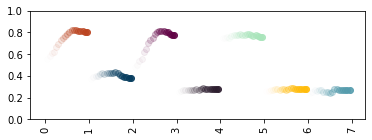

In [647]:
plt.figure(figsize = (6,2))
for interval in np.arange(0,200,10):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/200, np.round((np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval])+ np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224+interval:]))/2,2), alpha = (interval/200)*(interval/200), color = colorpal[iterate])
        iterate+=1
        plt.xticks(rotation = 90)
        plt.ylim(0,1)
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


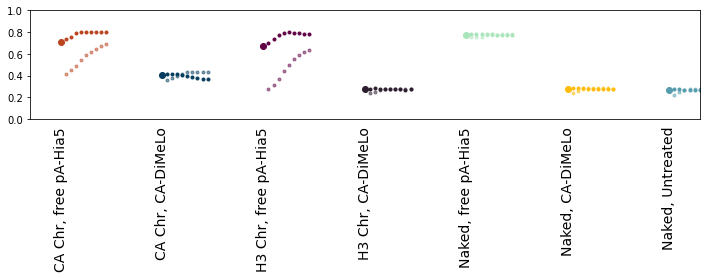

In [648]:
plt.figure(figsize = (12,2))
for interval in np.arange(0,200,20):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/400, np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval]),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.scatter(iterate + interval/400, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)),2), alpha = 1, color = colorpal[iterate], marker = '.')
        iterate+=1
        plt.tick_params(axis = 'x', bottom = False)
        plt.ylim(0,1)

iterate = 0
    
for Bar in Barcode_list:
    plt.scatter(Barcode_name[Bar], np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar]),2), color = colorpal[iterate])
    iterate+=1
    plt.xticks(rotation = 90, fontsize = 14)        
plt.show()

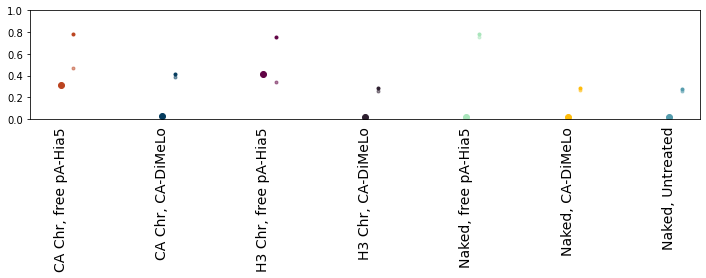

In [651]:
plt.figure(figsize = (12,2))
for interval in [50]:
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + interval/400, np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval]),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.scatter(iterate + interval/400, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)),2), alpha = 1, color = colorpal[iterate], marker = '.')
        iterate+=1
        plt.tick_params(axis = 'x', bottom = False)
        plt.ylim(0,1)

iterate = 0
    
for Bar in Barcode_list:
    plt.scatter(Barcode_name[Bar], np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)) - np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval]),2), color = colorpal[iterate])
    iterate+=1
    plt.xticks(rotation = 90, fontsize = 14)        
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


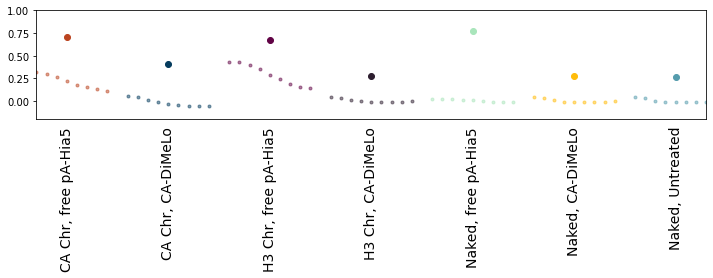

In [652]:
plt.figure(figsize = (12,2))
for interval in np.arange(0,200,20):
    iterate = 0
    for Bar in Barcode_list:
        plt.scatter(iterate + (-0.5 + interval/200), np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)) - np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval]),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        iterate+=1
        plt.tick_params(axis = 'x', bottom = False)
        plt.ylim(-0.2,1)

iterate = 0

for Bar in Barcode_list:
    plt.scatter(Barcode_name[Bar], np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar]),2), color = colorpal[iterate])
    iterate+=1
    plt.xticks(rotation = 90, fontsize = 14)        
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


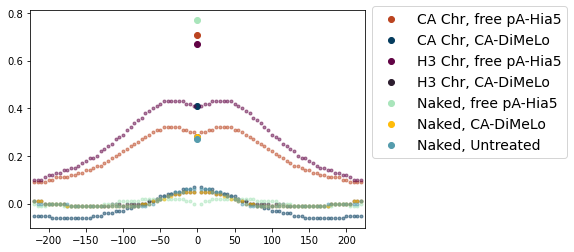

In [662]:
plt.figure(figsize = (6,4))
iterate = 0
    
for Bar in Barcode_list:
    for interval in np.arange(0,225,5):
    
        plt.plot(-interval, np.round(np.subtract(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)), np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval])),2), alpha = 0.5, color = colorpal[iterate], marker = '.')
        plt.plot(interval, np.round(np.subtract(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)), np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval])),2), alpha = 0.5, color = colorpal[iterate], marker = '.')

    iterate+=1

plt.xlim(-225,225)

iterate = 0
for Bar in Barcode_list:
    plt.scatter(0, np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar]),2), color = colorpal[iterate], label = Barcode_name[Bar])
    iterate+=1

plt.legend(fontsize = 14, bbox_to_anchor = (1,1.05))
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


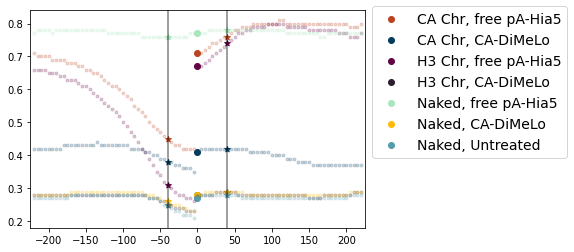

In [673]:
#LHS = average methylation within interval
#RHS = average methylation excluding interval
plt.figure(figsize = (6,4))
iterate = 0
    
for Bar in Barcode_list:
    for interval in np.arange(0,225,5):
    
        plt.plot(interval, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)),2), alpha = 0.2, color = colorpal[iterate], marker = '.')
        plt.plot(-interval, np.round((np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval])),2), alpha = 0.2, color = colorpal[iterate], marker = '.')

    iterate+=1

plt.xlim(-225,225)

iterate = 0
for Bar in Barcode_list:
    plt.scatter(0, np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar]),2), color = colorpal[iterate], label = Barcode_name[Bar])
    interval = 40
    plt.scatter(interval, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)),2), alpha = 1, color = colorpal[iterate], marker = '*')
    plt.scatter(-interval, np.round((np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval])),2), alpha = 1, color = colorpal[iterate], marker = '*')

    iterate+=1

plt.axvline(-interval, alpha = 0.5, color = 'black')
plt.axvline(interval, alpha = 0.5, color = 'black')


plt.legend(fontsize = 14, bbox_to_anchor = (1,1.05))
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


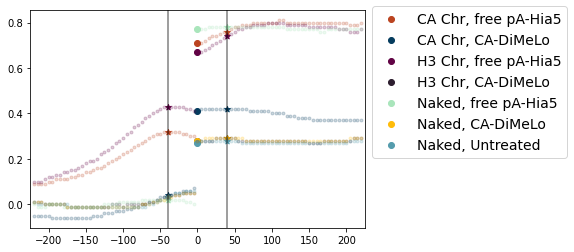

In [674]:
#LHS = average methylation difference between rest and valley (interval)
#RHS = average methylation excluding valley (interval)
plt.figure(figsize = (6,4))
iterate = 0
    
for Bar in Barcode_list:
    for interval in np.arange(0,225,5):
    
        plt.plot(-interval, np.round(np.subtract(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)), np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval])),2), alpha = 0.2, color = colorpal[iterate], marker = '.')
        plt.plot(interval, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)),2), alpha = 0.2, color = colorpal[iterate], marker = '.')
        
    iterate+=1

plt.xlim(-225,225)

iterate = 0
for Bar in Barcode_list:
    plt.scatter(0, np.round(np.nanmean(AT_prob_arr_bin_mA_trim450[Bar]),2), color = colorpal[iterate], label = Barcode_name[Bar])
    interval = 40
    plt.scatter(-interval, np.round(np.subtract(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)), np.nanmean(AT_prob_arr_bin_mA_trim450[Bar][:,224-interval:224+interval])),2), alpha = 1, color = colorpal[iterate], marker = '*')
    plt.scatter(interval, np.round(np.nanmean(np.delete(AT_prob_arr_bin_mA_trim450[Bar],np.arange(224-interval,224+interval), axis = 1)),2), alpha = 1, color = colorpal[iterate], marker = '*')

    iterate+=1

plt.axvline(-interval, alpha = 0.5, color = 'black')
plt.axvline(interval, alpha = 0.5, color = 'black')


plt.legend(fontsize = 14, bbox_to_anchor = (1,1.05))
plt.show()

#### Calculating FDR from CDF for binned probability:

In [134]:
#Calculating FDR from CDF

In [135]:
## Without masking on the center and edges

In [95]:
barcodes_list = [1,2,3,4,5,6,7,8]
histo_binned = {new_list: [] for new_list in barcodes_list}
bin_edges_binned = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar_binned = {new_list: [] for new_list in barcodes_list}
cdf_binned = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar_binned[i] = np.reshape(AT_prob_arr_bin_mA[i],-1)
    histo_binned[i], bin_edges_binned[i] = np.histogram(AT_prob_list_clean_bar_binned[i], density = True, bins=1000)
    cdf_binned[i] = np.cumsum(histo_binned[i])/np.nansum(histo_binned[i])
    

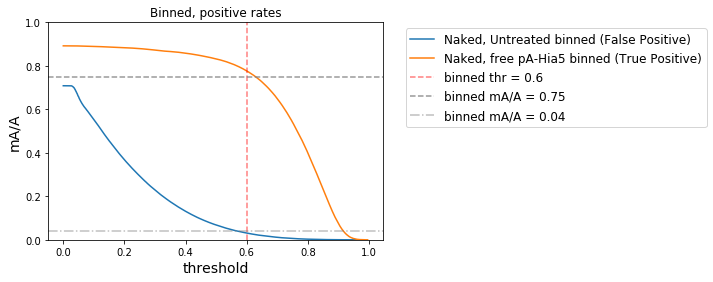

In [96]:
plt.plot(bin_edges_binned[8][:-1],1-cdf_binned[8], label = Barcode_name[8] + ' binned (False Positive)')
plt.plot(bin_edges_binned[7][:-1],1-cdf_binned[7], label = Barcode_name[7] + ' binned (True Positive)')
plt.ylabel('mA/A', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'binned thr = 0.6')
plt.axhline(0.75, color='grey', alpha=0.8, linestyle='--', label = 'binned mA/A = 0.75')
plt.axhline(0.04, color='grey', alpha=0.5, linestyle='-.', label = 'binned mA/A = 0.04')
plt.title('Binned, positive rates')
plt.ylim(0,1)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [106]:
def export_legend(legend, filename="legend.png"):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi=300, bbox_inches=bbox)
        return


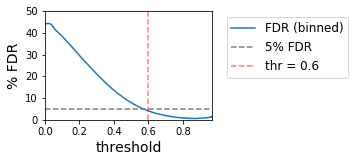

In [55]:
fig = plt.figure(figsize = (3,2))
plt.plot(bin_edges_binned[7][:-1],np.divide((1-cdf_binned[8]),((1-cdf_binned[7])+(1-cdf_binned[8])))*100, label = 'FDR (binned)' )
plt.ylabel('% FDR', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.6')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('Binned FDR, Naked DNA', fontsize = 14)
plt.ylim(0,50)
plt.xlim(0,0.97)
#plt.xlabel('threshold', fontsize=14)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig(outfolder+'FDR_50bp_Naked.png', dpi = 300, bbox_inches='tight')
export_legend(legend, str(outfolder + 'FDR50bp_Naked_legend.png'))
    
plt.show()


#### Calcualting FDR from binned probability scores after masking the center and edges

In [143]:
## Masking on the center and edges:
#In the following example and in the final figures, no masking was done over the center - hence mask_left = mask_right = 356

In [85]:
lefttrim = 160
righttrim = 610
mask_left = 356
mask_right = 356

In [86]:
AT_prob_arr_bin_mA_masktrim = {}
for i in [1,2,3,4,5,6,7,8]:
    AT_prob_arr_bin_mA_masktrim[i] = np.delete(AT_prob_arr_bin_mA[i][:,int(lefttrim/stepsize):int(righttrim/stepsize)],[int(b/stepsize) for b in range(mask_left - lefttrim,mask_right-lefttrim)], axis = 1)

In [149]:
histo_binned_masktrim = {new_list: [] for new_list in barcodes_list}
bin_edges_binned_masktrim = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar_binned_masktrim = {new_list: [] for new_list in barcodes_list}
cdf_binned_masktrim = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar_binned_masktrim[i] = np.reshape(AT_prob_arr_bin_mA_masktrim[i],-1)
    histo_binned_masktrim[i], bin_edges_binned_masktrim[i] = np.histogram(AT_prob_list_clean_bar_binned_masktrim[i], density = True, bins=1000)
    cdf_binned_masktrim[i] = np.cumsum(histo_binned_masktrim[i])/np.nansum(histo_binned_masktrim[i])
    

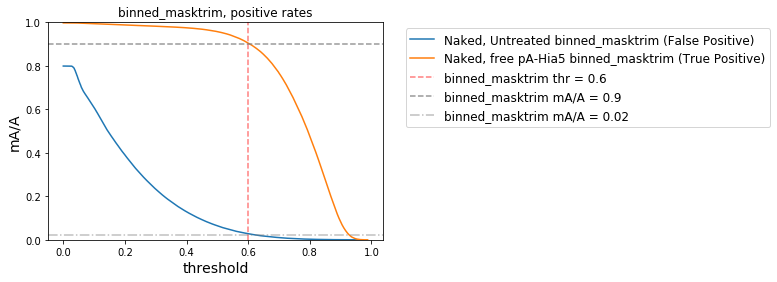

In [150]:
plt.plot(bin_edges_binned_masktrim[8][:-1],1-cdf_binned_masktrim[8], label = Barcode_name[8] + ' binned_masktrim (False Positive)')
plt.plot(bin_edges_binned_masktrim[7][:-1],1-cdf_binned_masktrim[7], label = Barcode_name[7] + ' binned_masktrim (True Positive)')
plt.ylabel('mA/A', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'binned_masktrim thr = 0.6')
plt.axhline(0.9, color='grey', alpha=0.8, linestyle='--', label = 'binned_masktrim mA/A = 0.9')
plt.axhline(0.02, color='grey', alpha=0.5, linestyle='-.', label = 'binned_masktrim mA/A = 0.02')
plt.title('binned_masktrim, positive rates')
plt.ylim(0,1)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

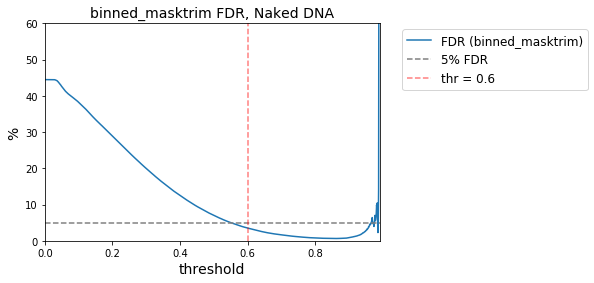

In [151]:
plt.plot(bin_edges_binned_masktrim[7][:-1],np.divide((1-cdf_binned_masktrim[8]),((1-cdf_binned_masktrim[7])+(1-cdf_binned_masktrim[8])))*100, label = 'FDR (binned_masktrim)' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.6')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('binned_masktrim FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


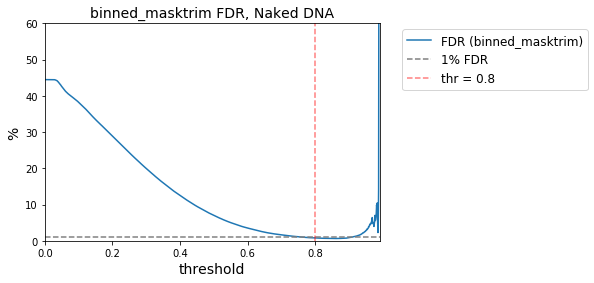

In [152]:
plt.plot(bin_edges_binned_masktrim[7][:-1],np.divide((1-cdf_binned_masktrim[8]),((1-cdf_binned_masktrim[7])+(1-cdf_binned_masktrim[8])))*100, label = 'FDR (binned_masktrim)' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(1, color='grey', linestyle='--', label = '1% FDR')
plt.axvline(0.8, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.8')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('binned_masktrim FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


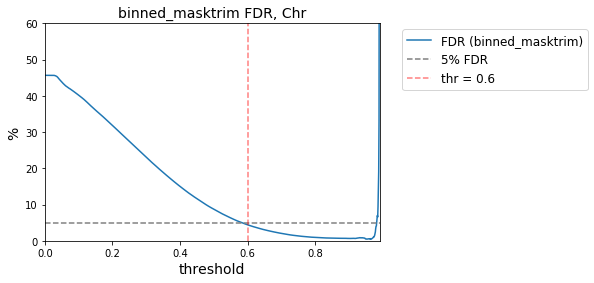

In [153]:
plt.plot(bin_edges_binned_masktrim[3][:-1],np.divide((1-cdf_binned_masktrim[4]),((1-cdf_binned_masktrim[3])+(1-cdf_binned_masktrim[4])))*100, label = 'FDR (binned_masktrim)' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.6')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('binned_masktrim FDR, Chr', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Calling nucleosomes on binned reads with > 0.2 methylation (thr 0.6)

In [332]:
#Identifying reads that have at least 20 % bins with average methylation probability > 0.6

In [191]:
nuc_called_reads_masktrim = {}
numbins = np.shape(AT_prob_arr_bin_mA_masktrim[1])[1]
print('ROI ', lefttrim, righttrim)
print('number of bins total = ', numbins)
print('total region considered', str(numbins * stepsize) + ' bp')
sensitivity = pd.DataFrame(index = [(Barcode_name[i]) for i in barcodes_list])
for numbins_threshold in [75]:
    thresh = numbins_threshold/numbins
    for i in barcodes_list:
        nuc_called_reads_masktrim[i] = np.sum(AT_prob_arr_bin_mA_masktrim[i] > 0.6, axis = 1)/numbins > thresh
        #same as :
        #nuc_called_reads_masktrim[i] = np.mean(AT_prob_arr_bin_mA_masktrim[i] > 0.8, axis = 1) > thresh
    #print('minimum number of methylated bins = ', numbins_threshold)
    #print(str(numbins_threshold*stepsize) + ' bp methylated out of ' + str(numbins*stepsize) + 'bp region')
    sensitivity[str(numbins_threshold)] = [(np.round(np.sum(nuc_called_reads_masktrim[i])/5000*100,1))  for i in barcodes_list]
sensitivity


ROI  160 610
number of bins total =  450
total region considered 450 bp


,75
"CA Chr, CA-DiMeLo",76.4
"CA Chr, IgG-DiMeLo",6.1
"CA Chr, free pA-Hia5",98.4
"CA Chr, Untreated",4.4
"Naked, CA-DiMeLo",16.8
"Naked, IgG-DiMeLo",14.6
"Naked, free pA-Hia5",98.5
"Naked, Untreated",4.9


In [97]:
lefttrim_only = 160
righttrim_only = 610

In [98]:
AT_prob_arr_bin_mA_trimonly = {}
for i in barcodes_list:
    AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

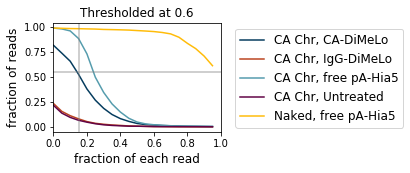

In [115]:
colorpal2 = ['#053C5E','#BB4420','#559CAD','#610345','#2D1E2F','#2D1E2F','#FFBC0A']
for frac in [0.6]:
    frac_methylated_read = {}
    fig = plt.figure(figsize = (3,2))

    for i in [1,2,3,4,7]:
        frac_methylated_read[i] = []
        for binfrac in np.arange(0,1,0.05):
            frac_methylated_read[i].append(np.sum((np.mean(AT_prob_arr_bin_mA_trimonly[i]>frac, axis = 1)>binfrac))/5000)

        
        plt.plot(np.arange(0,1,0.05), frac_methylated_read[i], label = Barcode_name[i], color = colorpal2[i-1])
    plt.axvline(0.15,0,1, color = 'grey', alpha = 0.5)
    #plt.axhline(0.05,0,1, color = 'grey', alpha = 0.5)
    plt.axhline(0.55,0,1, color = 'grey', alpha = 0.5)
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Thresholded at ' + str(frac), fontsize=12)
    plt.xlabel('fraction of each read', fontsize = 12)
    plt.ylabel('fraction of reads', fontsize = 12)
    plt.xlim(0,1)
    #plt.xlabel('threshold', fontsize=14)
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.savefig(outfolder+'fracVfrac_binned_threshold_wNkd'+str(int(frac*100))+'_hvlines.png', dpi = 300, bbox_inches='tight')
    export_legend(legend, str(outfolder + 'fracVfrac_binned_threshold_legend_wNkd.png'))

    plt.show()

In [95]:
sensitivity = pd.DataFrame(index = [(Barcode_name[i]) for i in barcodes_list])
sensitivity_norm = pd.DataFrame(index = [(Barcode_name[i]) for i in barcodes_list])

for halfwidth in [100,125,150,200,250,300,350]:

    lefttrim_only = 356 - halfwidth
    righttrim_only = 356 + halfwidth

    AT_prob_arr_bin_mA_trimonly = {}
    for i in barcodes_list:
        AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

    nuc_called_reads_trimonly = {}
    numbins = np.shape(AT_prob_arr_bin_mA_trimonly[1])[1]
    '''print('ROI ', lefttrim_only, righttrim_only)
    print('number of bins total = ', numbins)
    print('total region considered', str(numbins * stepsize) + ' bp')
    '''
    for numbins_threshold in [1]:
        thresh = numbins_threshold/numbins
        for i in barcodes_list:
            nuc_called_reads_trimonly[i] = (np.mean(AT_prob_arr_bin_mA_trimonly[i] > 0.6, axis = 1) > thresh)*(np.mean(AT_prob_arr_bin_mA_trimonly[i] > 0.8, axis = 1) < 1)
        #print('minimum number of methylated bins = ', numbins_threshold)
        #print(str(numbins_threshold*stepsize) + ' bp methylated out of ' + str(numbins*stepsize) + 'bp region')
        sensitivity[str(halfwidth)] = [(np.round(np.sum(nuc_called_reads_trimonly[i])/5000*100,2))  for i in barcodes_list]
        sensitivity_norm[str(halfwidth)] = [(np.round(np.sum(nuc_called_reads_trimonly[i])/np.sum(nuc_called_reads_trimonly[7])*100,2))  for i in barcodes_list]


In [163]:
for bp in ['A','T','AT']:
    AT_prob_arr_bar_filt50[bp] = np.zeros((5000,730))
    #AT_prob_arr_bar_filt50[bp][:] = np.NaN
for baseind in A_pos:
    AT_prob_arr_bar_filt50['A'][:,baseind] = 256
for baseind in T_pos:
    AT_prob_arr_bar_filt50['T'][:,baseind] = 256
for baseind in A_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 256
for baseind in T_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 256

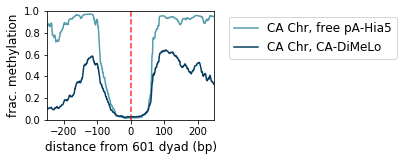

In [151]:
fig = plt.figure(figsize=(3,2))

a = {3:'#559CAD', 1:'#053C5E'}
for i in [3,1]:
    plt.plot(np.arange(0,np.shape(AT_prob_arr_bin_mA_trimonly[i])[1])-356+25,np.mean(AT_prob_arr_bin_mA_trimonly[i] > 0.6, axis = 0), color = a[i], label = Barcode_name[i])
    #legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title(str(binsize) + 'bp bin positions thresholded at ' + '0.6')
    plt.xlabel('distance from 601 dyad (bp)', fontsize=12)
    plt.ylabel('frac. methylation', fontsize = 12)
    plt.ylim(0,1)
    plt.xlim(-250,250)
    plt.axvline(0,0,1, linestyle = '--',color = 'red', alpha = 0.5)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(outfolder+'601_centered_325_08.png', dpi = 300, bbox_inches='tight')
export_legend(legend, str(outfolder + '601_centered_legend.png'))

plt.show()

In [164]:
for i in ['A', 'T', 'AT']:
    AT_prob_arr_bin_mA[i] = np.zeros((5000,int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        AT_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(AT_prob_arr_bar_filt50[i][:,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [165]:
for i in ['A', 'T', 'AT']:
    AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

In [380]:
fig = plt.figure(figsize=(3,1))

col = {'A':'#610345', 'T':'#5E747F'}
for i in ['A','T']:
    if i == 'A':
        alp = 0.7
    else:
        alp = 0.9
    plt.plot(np.arange(0,np.shape(AT_prob_arr_bin_mA_trimonly[i])[1])-356+25,np.mean(AT_prob_arr_bin_mA_trimonly[i], axis = 0), color = col[i], label = Barcode_name[i], alpha = alp)
    #legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title(str(binsize) + 'bp bin positions thresholded at ' + '0.6')
    plt.xlabel('distance from 601 dyad (bp)', fontsize=12)
    plt.ylabel('A or T / 50 bp', fontsize = 12)
    plt.ylim(0,0.5)
    plt.xlim(-250,250)
    plt.axvline(0,0,1, linestyle = '--',color = 'red', alpha = 0.5)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(outfolder+'601_centered_325_ATper50bp.png', dpi = 300, bbox_inches='tight')
export_legend(legend, str(outfolder + '601_centered_250_ATper50bp_legend.png'))

plt.show()

NameError: name 'AT_prob_arr_bin_mA_trimonly' is not defined

<Figure size 216x72 with 0 Axes>

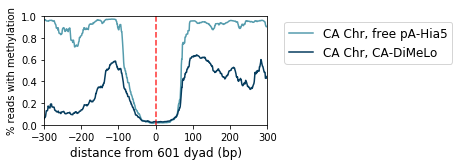

<function matplotlib.pyplot.show>

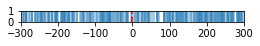

In [170]:
fig = plt.figure(figsize=(4,2))

a = {3:'#559CAD', 1:'#053C5E'}
for i in [3,1]:
    plt.plot(np.arange(0,np.shape(AT_prob_arr_bin_mA[i])[1])-(356),np.mean(AT_prob_arr_bin_mA[i] > 0.6, axis = 0), color = a[i], label = Barcode_name[i])
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title(str(binsize) + 'bp bin positions thresholded at ' + '0.6')
    plt.xlabel('distance from 601 dyad (bp)', fontsize=12)
    plt.ylabel('% reads with methylation')
    plt.ylim(0,1)
    plt.xlim(-300,300)
    plt.axvline(0,0,1, linestyle = '--',color = 'red', alpha = 0.5)
plt.show()

plt.figure(figsize = (4,0.2))
for bp in A_pos:
    plt.axvline(bp-356,alpha =0.5)
    plt.ylim(0,1)
for bp in T_pos:
    plt.axvline(bp-356,alpha = 0.5)
    plt.ylim(0,1)
    plt.xlim(-300,300)
plt.axvline(0, 0,1, color='red', linestyle='--')

plt.show


In [ ]:
## Trying effect of binning size on these aggregate plotes:

### Clustering reads by bins with methylation > thr

In [675]:
d_rows={}
row_linkage_mod = {}

In [679]:
for i in ['21','22']:

    d_rows[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim450[i]>0.6),metric='jaccard')

    row_linkage_mod[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)

In [677]:
m6ABlue = sns.light_palette("#053C5E", 1000)
m6ABlue[0] = (1,1,1)

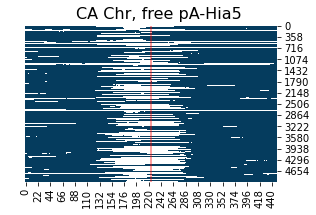

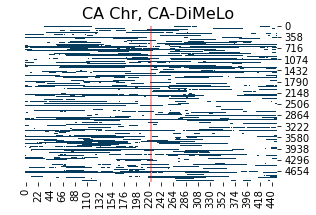

In [685]:
for i in ['21','22']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim450[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=False, col_cluster=False, row_linkage=None, col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(224,0,1, color = 'red', alpha = 0.5)
    #plt.axvline(606,0,1, color = 'g', alpha = 0.5)
    #plt.axvline(106,0,1, color = 'g', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'noncluster_mod06_' + str(i) + '.png', dpi=300)
    clstmap.savefig(outfolder + 'noncluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

In [681]:
d_rows2={}
row_linkage_mod2 = {}

In [682]:
for i in ['21','22']:

    d_rows2[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim450[i]>0.6),metric='jaccard')

    row_linkage_mod2[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)

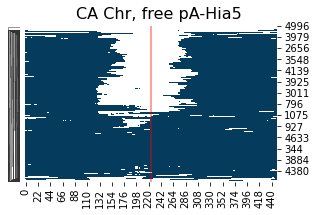

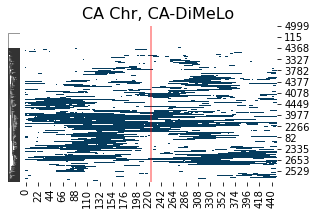

In [684]:
for i in ['21','22']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim450[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(224,0,1, color = 'red', alpha = 0.5)
    #plt.axvline(606,0,1, color = 'g', alpha = 0.5)
    #plt.axvline(106,0,1, color = 'g', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.png', dpi=300)
    clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()